In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc
from matplotlib import pyplot as plt
import scmulti

In [4]:
%config InlineBackend.figure_format = 'retina'

# Load the dataset

In [5]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40018
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

# Configure and train the model

In [24]:
model = scmulti.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]],
    condition = '1', #conditional version '0' or '1', comment out or set to None if not conditional
    z_dim=20,
    h_dim=128,
    hiddens=[],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [26]:
model.train(
    n_iters=100,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    validate_every=30
)

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


 |██████--------------| 31.0% iter=31/100, time=102.81(s), loss=0.7644, recon=0.6635, kl=6.4589, integ=10.0906, val_loss=40.4085, val_recon=0.4767, val_kl=6.2151, val_integ=9.2711
 |████████████--------| 61.0% iter=61/100, time=96.62(s), loss=0.5928, recon=0.4989, kl=6.9401, integ=9.3882, val_loss=33.0681, val_recon=0.3778, val_kl=7.6901, val_integ=8.8487
 |██████████████████--| 91.0% iter=91/100, time=101.28(s), loss=0.5072, recon=0.4169, kl=8.3322, integ=9.0213, val_loss=28.7224, val_recon=0.3209, val_kl=9.2425, val_integ=8.3198
 |████████████████████| 100.0% iter=100/100, time=89.04(s), loss=0.4907, recon=0.4014, kl=8.8005, integ=8.9149, val_loss=27.8971, val_recon=0.3101, val_kl=9.6817, val_integ=8.2533


## Plot training history

In [27]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,val_loss,val_recon,val_kl,val_integ
0,30,0.764447,0.663476,6.458905,10.090648,40.408525,0.476675,6.215082,9.271116
1,60,0.592827,0.498876,6.940084,9.388152,33.068131,0.377754,7.690117,8.848688
2,90,0.507184,0.416888,8.332233,9.021259,28.722440,0.320920,9.242547,8.319816
3,99,0.490682,0.401445,8.800489,8.914886,27.897092,0.310130,9.681711,8.253337


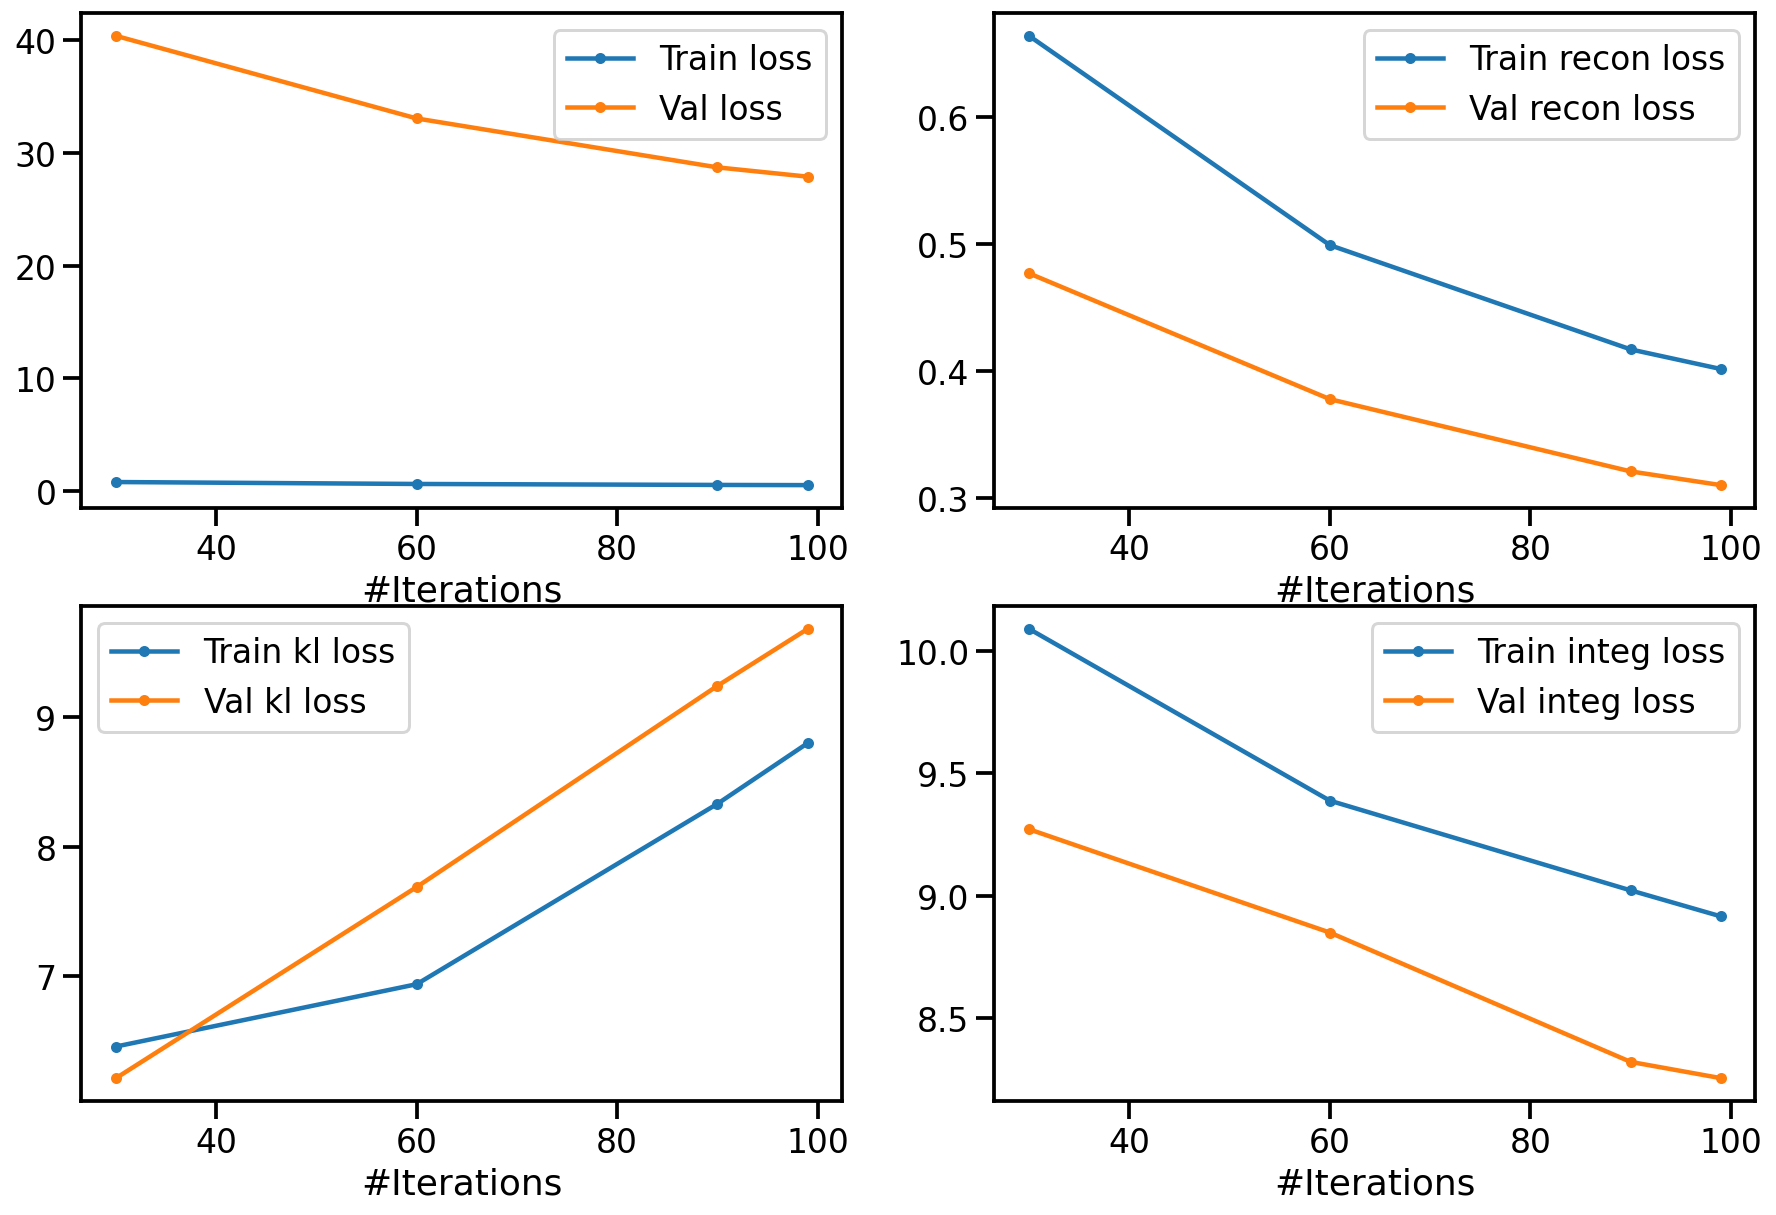

In [28]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

In [29]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    batch_size=64,
)
z

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 20000 × 20
    obs: 'modality', 'cell_type', 'batch'

In [67]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


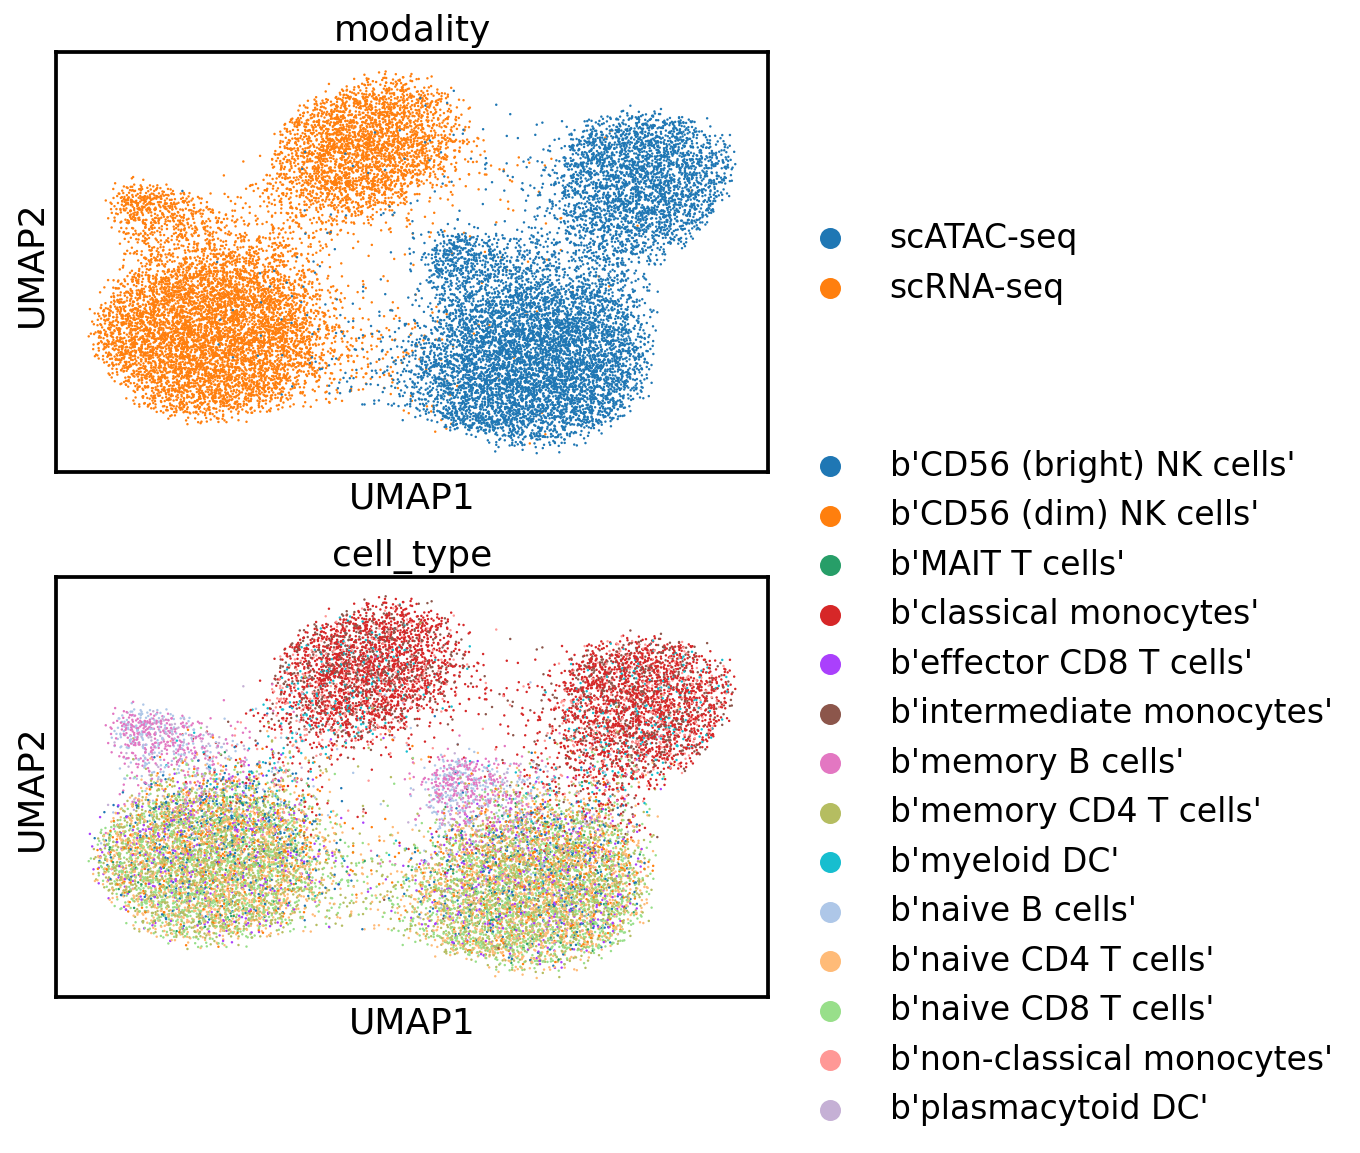

In [68]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

In [14]:
scmulti.metrics.nmi(z, label_key='modality')

2.4718318713065635e-06

In [15]:
scmulti.metrics.asw(z, label_key='modality')

0.0006791786290705204

In [16]:
scmulti.metrics.asw(z, label_key='cell_type')

0.12380161136388779

In [26]:
sc.pp.pca(z)
metrics = scmulti.metrics.scibmetrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    hvg_score_=False,
    nmi_=True,
    ari_=True,
    silhouette_=True,
)
metrics

clustering...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/sit

NMI...
ARI...
silhouette score...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi

,0
NMI_cluster/label,0.670802
ARI_cluster/label,0.503553
ASW_label,0.553201
ASW_label/batch,0.917820
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,NaN
graph_conn,NaN
kBET,NaN
